In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '../data/'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  # residual
  r = s - D @ x

  # support set
  omega = [] 
  
  while np.linalg.norm(r) > tau and len(omega) < L:
    # SWEEP STEP
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (r.T @ dj)**2 / np.linalg.norm(dj)**2

    # find the column of D that matches best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega:
        omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s||
    D_omega = D[:, omega]
    x_w, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)
    for j, w in zip(omega, x_w.flatten()): 
        x[j] = w

    # update the residual
    r = s - D @ x

  return x

Load the image and rescale it in $[0,1]$

In [5]:
img = imread(f'{rootfolder}cameraman.png') / 255
# img = imread(f'{rootfolder}barbara.png') / 255
# img = imread(f'{rootfolder}Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image

In [6]:
npatch = 10000

S = np.zeros((M, npatch))
# extract npatch random pxp (flattened to M) patches from the image
for i in range(npatch):
    x = np.random.randint(0, imsz[0] - p)
    y = np.random.randint(0, imsz[1] - p)
    S[:, i] = img[x:x+p, y:y+p].flatten()

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [7]:
S = S - np.mean(S, axis=0)


Initialize the dictionary and the coefficient matrix

In [8]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = np.random.rand(M, N)

# normalize each column of D (zero mean and unit norm)
D -= np.mean(D, axis=0)
norms = np.linalg.norm(D, axis=0)
D /= norms

# number of iteration of the KSVD
max_iter = 5

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))


Main KSVD loop


In [9]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
      X[:, n] = OMP(S[:, n], D, L, 1e-3)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.nonzero(X[j, :])[0]

        if len(omega) == 0:
            D[:, j] = np.random.rand(M)
            D[:, j] -= D[:, j].mean()  # Remove mean
            D[:, j] /= np.linalg.norm(D[:, j])  # Normalize
        else:
            # compute the residual matrix E, ignoring the j-th atom
            E = S - (D @ X - np.outer(D[:, j], X[j, :]))

            # restrict E to the columns indicated by omega
            Eomega = E[:, omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

            # update the dictionary
            D[:, j] = U[:, 0]

            # update the coefficient matrix
            X[j, omega] = Sigma[0] * V[0, :]
    
    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
94
iter 1
93
iter 2
90
iter 3
94
iter 4
96


Show the learned dictionary

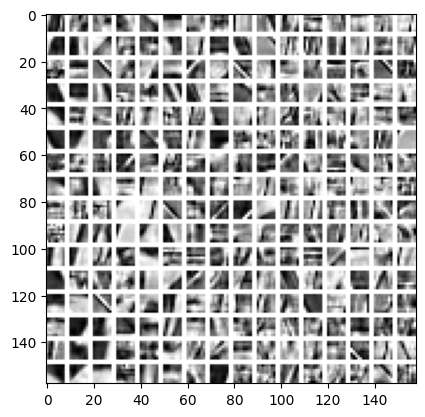

In [10]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')
